In [552]:
%load_ext blackcellmagic

from isolation import Isolation, DebugState
from my_custom_player import MAX_BOOK_LEVEL
import itertools
import random

WIDTH = 11
PADDED_WIDTH = WIDTH + 2 # Adjusting for our soft bitmap border
HEIGHT = 9

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


## Populate Opening Book

**Goal:** have a quick-to-use playbook that allows our agent to select a set of opening moves.

**Approach:** I''ll probabalistically sample random depth-first-searches given particular starting moves, finding the win-loss ratios at each. These ratios can then be used by an agent to select a set of opening moves that (usually) win. According to [theory on board-filling games](https://link.springer.com/chapter/10.1007%2F978-3-642-31866-5_22), randomly rolling out games and using win-loss ratios as a heuristic asyptotically approaches optimal MiniMax as you sample more games.

We are collecting possible positions in the first `MAX_BOOK_LEVEL` levels of the game after a first choice is made.

In [548]:
print("MAX_BOOK_LEVEL is ", MAX_BOOK_LEVEL)

MAX_BOOK_LEVEL is  5


In [549]:
BOOK = {}

It's possible to sample only from a limited starting set, and take advantage of symmetry to infer what the combinations would be given a different starting position.

We will use the bottom-right portion of the board as the canoncial "starting quadrant".

![alt text](img/911symmetries.png)


In [547]:
def xy2ind(x, y):
    """
    Return a bitboard index for an x,y pair, where the (0,0) coordinate is bottom-right
    and values increase to the left and upward.
    """
    return PADDED_WIDTH * y + x


# Calculate the minimum set of positions we need to capture data
# that is generalizable via symmetry
starting_set = [xy2ind(x, y) for x, y in itertools.product(range(6), range(5))]

Given this starting set of points, we'll initialize a book with all possible paths through `MAX_BOOK_LEVEL` plies.

In [157]:
# Calculate the second set of positions possible given the starting set of positions
def get_next_positions(action):
    game = Isolation()
    game = game.result(action)
    game.player = lambda: 0

    next_positions = []
    for action in game.actions():
        res = game.result(action)
        next_positions.append(res.locs[0])

    return next_positions


def expand_path(path):
    """
    Expand a path by returning the next set of viable moves,
    where 'path' is a tuple of p1 and p2 positions: (p1_position, p2_position, p1_position, ...)
    
    Returns a list of expanded paths.
    """
    assert (
        len(path) >= 2
    ), "Can only expand paths with where there are at least 2 arbitrary moves chosen"
    next_positions = get_next_positions(
        path[-2]
    )  # next move depends on what move was tried before, which was 2-back

    return [
        tuple(list(path) + [next_position])
        for next_position in next_positions
        if next_position not in path # ensure we never occupy a discarded square
    ]


def get_canonical_book(starting_set, level=3):
    assert level % 2 == 1, "Only odd levels are useful for player 1!"
    assert level >= 3, "We must create a book with more than 3 levels to be useful."

    p2_starting_set = (
        Isolation().actions()
    )  # player 2 can take any free position (that hasn't been occupied)
    book = {}

    element = {"wins": 0, "losses": 0}

    # Seed book with starting sets.
    # The book's keys are action paths through: (p1_position, p2_position, p1_position, ...) etc.
    book.update({(x,): element.copy() for x in starting_set})
    book.update(
        {
            (x, y): element.copy()
            for x, y in itertools.product(starting_set, p2_starting_set)
            if x != y
        }
    )  # level 2

    for level in range(3, level + 1):
        last_level_keys = [k for k in book.keys() if len(k) == level - 1]

        # For each key, expand it with the next set of possible moves.
        key_expansions = [expand_path(path) for path in last_level_keys]
        key_expansions = [path for paths in key_expansions for path in paths]  # flatten

        book.update({path: element.copy() for path in key_expansions})

    return book

In [542]:
BOOK = get_canonical_book(starting_set, MAX_BOOK_LEVEL)

In [543]:
print(f"Book contains {len(BOOK)} keys.")

Book contains 644292 keys.


## Simulation

Given a book with keys that contain all possible paths through the first `MAX_BOOK_LEVELS` plies of the game, we need count wins and losses for each book.

This is done via simulation--where we try random moves until reaching a terminal state, attributing a win or a loss to the first 5 moves. To keep things simple, we only calculate wins and losses from the perspective of the starting player.

The book is quite giant, and we need enough trials to get at least 100 or so samples for each combination of starter moves. This means lots and lots of simulation.

In [551]:
from multiprocessing import Pool

# Simulate and count wins vs losses

def simulate(sims):
    book = BOOK.copy()
    for sim in range(sims):
        game = Isolation()

        action = random.choice(starting_set)
        positions = [action] # the first 'action' is a position on the board
        
        game = game.result(action)

        # Random choices until terminal state
        while not game.terminal_test():
            action = random.choice(game.actions())
            active_player = game.player()
            game = game.result(action)
            
            if len(positions) < MAX_BOOK_LEVEL:
                positions.append(game.locs[active_player])

        win = game.utility(0) == float("inf")

        for terminal_idx in range(1, MAX_BOOK_LEVEL + 1):
            key = tuple(positions[0:terminal_idx])
            if win:
                book[key]["wins"] += 1
            else:
                book[key]["losses"] += 1
    
    return book

In [198]:
with Pool(processes=7) as pool:
    %time books = pool.map(simulate, [int(1e7)]*7)

CPU times: user 23.7 s, sys: 9.81 s, total: 33.5 s
Wall time: 13h 10min 10s


In [ ]:
# Reduce step
from functools import reduce

def reduce_book(main_book, marginal_book):
    for k,v in marginal_book.items():
        main_book[k]["wins"] += v["wins"]
        main_book[k]["losses"] += v["losses"]
    
    return main_book

%time resulting_book = reduce(reduce_book, [BOOK.copy(), resulting_book] + books)

CPU times: user 4.23 s, sys: 568 ms, total: 4.8 s
Wall time: 5.12 s


This work is long and tedious. I broke it up into multiple runs and versioned each resulting book, in case I made any mistakes somewhere down the line during my manual process.

In [ ]:
import pickle
import os

def save_book(version):
    filename = f"data/book_{version}.pkl"
    assert not os.path.exists(filename), "Don't overwrite your file!"
    with open(filename, 'wb') as f:
        pickle.dump(resulting_book, f)
        
save_book(10)

## Calculate win/loss ratios for each path

To have a usable data structure for an agent, we finally save a simple flat map of all possible paths (starting from our starting quadrant) to its win/loss ratio, so the agent can intelligently minimize or maximize.

Paths not starting in a starting quadrant can be transformed into paths that **do** using logic inside `transform.py`.

In [450]:
with open('data/book_10.pkl', 'rb') as f:
    full_book = pickle.load(f)

In [452]:
full_book = {k: v["wins"] / (v["wins"] + v["losses"] + 1e-6) for k,v in full_book.items()}

In [521]:
def save_ratio_book(book, version):
    filename = f"data.pickle"
    assert not os.path.exists(filename), "Don't overwrite your file!"
    with open(filename, 'wb') as f:
        pickle.dump(book, f)
        
save_ratio_book(full_book, 0)

## Insights

Based on results from the book, we can make certain insights about every level of the tree. At the first level:

In [557]:
ply_1_book = {k:v for k,v in full_book.items() if len(k) == 1}

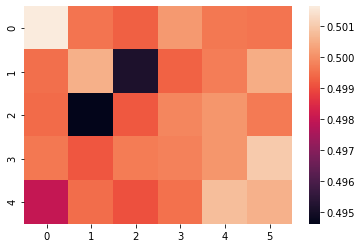

In [571]:
import numpy as np
import seaborn as sns

def display_grid(grid, ply_book, path_idx):
    for ind in ply_book.keys():
        x, y = DebugState.ind2xy(ind[path_idx])
        grid[y, x] = ply_book[ind]
    sns.heatmap(grid)

# Display the win-ratio grid for a starter move
grid = np.zeros([5, 6])
display_grid(grid, ply_1_book, 0)

These results are for just one quadrant (the upper right, in this case), but can be superimposed on any quadrant of the board if flipped and rotated appropriately.

Surprisingly the most favorable place to begin is in a corner, or close to the center along the central crossbar.

If chosen, the second player has the following options:

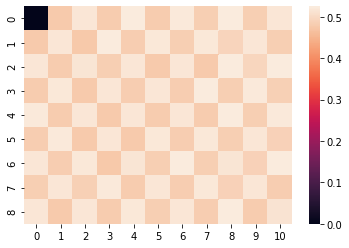

In [573]:
ply_2_book = {k:v for k,v in full_book.items() if len(k) == 2 and k[0] == 0}
grid_2 = np.zeros([HEIGHT, WIDTH])

display_grid(grid_2, ply_2_book, 1)

A gridlike pattern emerges, where any placement upon that grid is favorable (in this case, the lower ratios).


## Results

I ran multiple rounds at many depth-limit settings, artificially constraining how deep my MiniMax agent could traverse the tree before ceasing a search. The heuristic was the familiar $Liberties_{my} - Liberties_{opponent}$ from the lectures.

Each row is the result of 100 trials between my Custom Agent and the Greedy Agent. In cases where the Book was used, the Book's values for particular paths through the tree were used to inform the heuristic score if decisions were being made at a ply the Book had values for. In the corresponding Baseline case, these choices were made at random. In both cases, for plies beyond what was covered by the book, both conditions allowed agents to simply do Minimax using our selected heuristic.

**Raw Data**

| Depth Limit  | With Book  | Baseline   | 
|---|---|---|
| 1  | 50% | 24%  |
| 2  | 50%  |  30% |
| 3  |  0%<super>*</super> | 34%  | 
| 4 |   49%   |  37%   |
| 5 | 50% | 37% |
| 6 | 37% | 39% |
| 7 |   50%  |  44%  |
| 8 |  47%  |  47%  |
| 9 |  49%  |  48%  |
| 10 | 50% | 45%   | 
| $\infty$ | 47%  |  43.0%  |

**Interpretation**

The Book is mainly an asset in games where there is little time to make decisions. When we artificially limit depth to mimic timeout conditions, an agent with book access performs far better than the Baseline case.

As we allow deeper Minimax traversals, even agents with completely random opening moves seem able to recover and match pace with Book agents.

<super>*</super> This was a surprising case that suggests some mistraining of the book. It needs further debugging.